This code makes the skew ts for the interpolated sonde data. 0 = 00:00, 359 = 0

"""
Stores the class for SkewTDisplay.

"""

import warnings
import act
import act.plotting

# Import third party libraries
import matplotlib.pyplot as plt
import metpy
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import numpy as np
import scipy
import pandas as pd

from copy import deepcopy

# Import Local Libs
# import utils as dt_utils
#import Display
from act.plotting import Display,SkewTDisplay
from act.utils import datetime_utils as dt_utils

In [3]:
#function
class SkewTDisplaySond(SkewTDisplay):        
    def __init__(self, obj):
        super().__init__(obj)
                         
    def plot_from_u_and_v_sond(
        self,
        u_field,
        v_field,
        p_field,
        t_field,
        td_field,
        dsname=None,
        subplot_index=(0,),
        p_levels_to_plot=None,
        show_parcel=True,
        shade_cape=True,
        shade_cin=True,
        set_title=None,
        smooth_p=3,
        plot_barbs_kwargs=dict(),
        plot_kwargs=dict(),
    ):
        
        """
        This function will plot a Skew-T from a sounding dataset. The wind
        data must be given in u and v.

        Parameters
        ----------
        u_field : str
            The name of the field containing the u component of the wind.
        v_field : str
            The name of the field containing the v component of the wind.
        p_field : str
            The name of the field containing the pressure.
        t_field : str
            The name of the field containing the temperature.
        td_field : str
            The name of the field containing the dewpoint temperature.
        dsname : str or None
            The name of the datastream to plot. Set to None to make ACT
            attempt to automatically determine this.
        subplot_index : tuple
            The index of the subplot to make the plot on.
        p_levels_to_plot : 1D array
            The pressure levels to plot the wind barbs on. Set to None
            to have ACT to use neatly spaced defaults of
            50, 100, 200, 300, 400, 500, 600, 700, 750, 800,
            850, 900, 950, and 1000 hPa.
        show_parcel : bool
            Set to True to show the temperature of a parcel lifted
            from the surface.
        shade_cape : bool
            Set to True to shade the CAPE red.
        shade_cin : bool
            Set to True to shade the CIN blue.
        set_title : None or str
            The title of the plot is set to this. Set to None to use
            a default title.
        smooth_p : int
            If pressure is not in descending order, will smooth the data
            using this many points to try and work around the issue.
            Default is 3 but inthe pbl retrieval code we have to default to 5 at times
        plot_barbs_kwargs : dict
            Additional keyword arguments to pass into MetPy's
            SkewT.plot_barbs.
        plot_kwargs : dict
            Additional keyword arguments to pass into MetPy's
            SkewT.plot.

        Returns
        -------
        ax : matplotlib axis handle
            The axis handle to the plot.

        """
        
        if dsname is None and len(self._obj.keys()) > 1:
            raise ValueError(
                'You must choose a datastream when there are 2 '
                'or more datasets in the TimeSeriesDisplay '
                'object.'
            )
        elif dsname is None:
            dsname = list(self._obj.keys())[0]

        if p_levels_to_plot is None:
            p_levels_to_plot = np.array(
                [
                    50.0,
                    100.0,
                    200.0,
                    300.0,
                    400.0,
                    500.0,
                    600.0,
                    700.0,
                    750.0,
                    800.0,
                    850.0,
                    900.0,
                    950.0,
                    1000.0,
                ]
            ) * units('hPa')

        # Get pressure and smooth if not in order
        p = self._obj[dsname][p_field]
        # print(p)
        # p = p[~np.isnan(p)]
        
        if not all(p[i] <= p[i + 1] for i in range(len(p) - 1)):
            self._obj[dsname][p_field] = (
                self._obj[dsname][p_field].rolling(time=smooth_p, min_periods=1, center=True).mean()
            )
            p = self._obj[dsname][p_field]

        p_units = self._obj[dsname][p_field].attrs['units']
        p = p.values * getattr(units, p_units)

        T = self._obj[dsname][t_field]
        T_units = self._obj[dsname][t_field].attrs['units']
        if T_units == 'C':
            T_units = 'degC'

        T = T.values * getattr(units, T_units)
        Td = self._obj[dsname][td_field]
        Td_units = self._obj[dsname][td_field].attrs['units']
        if Td_units == 'C':
            Td_units = 'degC'

        Td = Td.values * getattr(units, Td_units)
        u = self._obj[dsname][u_field]
        u_units = self._obj[dsname][u_field].attrs['units']
        u = u.values * getattr(units, u_units)

        v = self._obj[dsname][v_field]
        v_units = self._obj[dsname][v_field].attrs['units']
        v = v.values * getattr(units, v_units)

        u_red = np.zeros_like(p_levels_to_plot) * getattr(units, u_units)
        v_red = np.zeros_like(p_levels_to_plot) * getattr(units, v_units)

        # Check p_levels_to_plot units, and convert to p units if needed
        if not hasattr(p_levels_to_plot, 'units'):
            p_levels_to_plot = p_levels_to_plot * getattr(units, p_units)
        else:
            p_levels_to_plot = p_levels_to_plot.to(p_units)

        v = np.ravel(v[:, ~np.isnan(v).any(axis=0)])
        u = np.ravel(u[:, ~np.isnan(u).any(axis=0)])
        p = np.ravel(p[:, ~np.isnan(p).any(axis=0)])
        Td = np.ravel(Td[:, ~np.isnan(Td).any(axis=0)])
        T = np.ravel(T[:, ~np.isnan(T).any(axis=0)])

        for i in range(len(p_levels_to_plot)):
            index = np.argmin(np.abs(p_levels_to_plot[i] - p))
            u_red[i] = u[index].magnitude * getattr(units, u_units)
            v_red[i] = v[index].magnitude * getattr(units, v_units)

        self.SkewT[subplot_index].plot(p, T, 'r', **plot_kwargs)
        self.SkewT[subplot_index].plot(p, Td, 'g', **plot_kwargs)
        self.SkewT[subplot_index].plot_barbs(
            p_levels_to_plot.magnitude, u_red, v_red, **plot_barbs_kwargs
        )

        # Metpy fix if Pressure does not decrease monotonically in
        # your sounding.
        try:
            prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
        except metpy.calc.exceptions.InvalidSoundingError:
            p = scipy.ndimage.median_filter(p, 3, output=float)
            p = metpy.units.units.Quantity(p, p_units)
            prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

        if show_parcel:
            # Only plot where prof > T
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
            self.SkewT[subplot_index].plot(
                lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black', **plot_kwargs
            )
            self.SkewT[subplot_index].plot(p, prof, 'k', linewidth=2, **plot_kwargs)

        if shade_cape:
            self.SkewT[subplot_index].shade_cape(p, T, prof, linewidth=2)

        if shade_cin:
            self.SkewT[subplot_index].shade_cin(p, T, prof, linewidth=2)

        # Set Title
        if set_title is None:
            set_title = ' '.join(
                [
                    dsname,
                    'on',
                    dt_utils.numpy_to_arm_date(self._obj[dsname].time.values[0]),
                ]
            )

        self.axes[subplot_index].set_title(set_title)

        # Set Y Limit
        our_data = p.magnitude
        if np.isfinite(our_data).any():
            yrng = [np.nanmax(our_data), np.nanmin(our_data)]
        else:
            yrng = [1000.0, 100.0]
        # COMMENT OUT THIS LINE TO MAKE THE PLOT
        # self.set_yrng(yrng, subplot_index)

        # Set X Limit
        xrng = [np.nanmin(T.magnitude) - 10.0, np.nanmax(T.magnitude) + 10.0]
        self.set_xrng(xrng, subplot_index)

        return self.axes[subplot_index]

In [7]:
#test file
import xarray
import act
t=xarray.open_dataset('/global/cscratch1/sd/laart/Sond/gucinterpolatedsondeM1.c1.20220314.000030.nc')
t.time
x=t.isel(time=[359])
#t.isel(time=[0])
#^gives the first timing udnder
#get the pres field to be bar_pres
#get tdry field to be temp
#bar_pres is in kpa so I need to get to hpa by multiplying by ten.
#Keep the u and v fields the same and the dewpoint the same. 

<xarray.DataArray 'bar_pres' (time: 1, height: 332)>
[332 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2022-03-14T05:59:30
  * height   (height) float32 2.886 2.906 2.926 2.946 ... 111.5 112.0 112.5
Attributes:
    long_name:            Barometric pressure
    units:                kPa
    standard_name:        air_pressure
    valid_min:            0.0
    valid_max:            110.0
    ancillary_variables:  qc_bar_pres source_bar_pres


<SkewXAxesSubplot: title={'center': 'March 14, 2022 00:00 interpolated Sonde'}, xlabel='degree_Celsius', ylabel='hectopascal'>

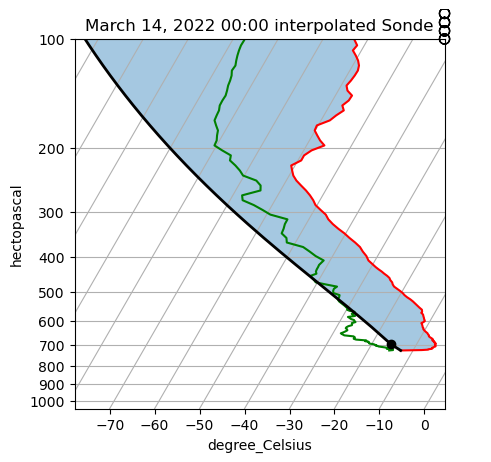

In [16]:
#one specific plot
sonde_ds = act.io.armfiles.read_netcdf("/global/cscratch1/sd/laart/Sond/gucinterpolatedsondeM1.c1.20220110.000030.nc")
x = sonde_ds.isel(time=[0])
SkewT = SkewTDisplaySond(x)
SkewT.plot_from_u_and_v_sond('u_wind', 'v_wind', 'bar_pres', 'temp', 'dp', set_title="March 14, 2022 00:00 interpolated Sonde")


In [1]:
#Loop for all 0:00 inthe directory
#directory = '/global/cscratch1/sd/laart/Sond/'
#from pathlib import Path

#files = Path('/global/cscratch1/sd/laart/Sond/').glob('*')
#for file in files:
#    print(file)
#   sonde_ds = act.io.armfiles.read_netcdf(str(file))
#    x = sonde_ds.isel(time=[0])
#    SkewT = SkewTDisplaySond(x)
#    SkewT.plot_from_u_and_v_sond('u_wind', 'v_wind', 'bar_pres', 'temp', 'dp')
#    #plt.savefig('/global/cscratch1/sd/laart/'+str(file)[-19:]+'_6:00.png', format='png')
#    plt.savefig('/global/cscratch1/sd/laart/int_sonde_00:00/00:00_'+str(file)[-19:]+'.png', format='png')
#    plt.show()
    #break